# Kaggle Titanic Competition

## Import raw data

In [4]:
import csv

with open('data/train.csv',newline='') as csvFile:

    reader = csv.reader(csvFile, delimiter=',')

    l = list(reader)
    header = l[0]
    rawData = l[1:]
    allLabels = [passenger[1] for passenger in rawData]

## Get normalized numeric data

In [5]:
# corresponding integers for values of given field
def getNumericDict(rawData, field):

    allData = {passenger[field] for passenger in rawData}

    numericDict = {}
    i = 0

    for datum in allData:
        numericDict[datum] = i
        i += 1

    return numericDict

# convert some string fields to numbers and gather results
def parseRawData(rawData, convertFields, numericFields, numericDicts):

    data = []
    
    for passenger in rawData:
        numeric = [passenger[i] for i in numericFields]
        converted = [numericDicts[i][passenger[i]] for i in convertFields]

        passengerData = [float(f) if f!='' else 0 for f in numeric+converted]
        data.append(passengerData)
    return data

# scale data into range (0,1) using numpy
import numpy as np

def normalizeData(data):
    npData = np.array(data,dtype=float)
    maxes = np.amax(npData, axis=0)
    mins = np.amin(npData, axis=0)
    maxes = np.where(maxes==0,.001,maxes) - mins[None,:]

    return (npData-mins[None,:])/maxes

In [6]:
numericFields = [2,5,6,7,9]
convertFields = [4,11]

numericDicts = {field:getNumericDict(rawData,field) for field in convertFields}
data = parseRawData(rawData,convertFields,numericFields,numericDicts)
normData = normalizeData(data)

In [7]:
# simple validation data separation
# TODO: change to k-fold

valSplit = 600

trainData = normData[:valSplit]
validData = normData[valSplit:]

trainLabels = np.asarray(allLabels[:valSplit], dtype=float)
validLabels = np.asarray(allLabels[valSplit:], dtype=float)

## Build model

In [8]:
from keras import models
from keras import layers

inputLen = trainData.shape[1]

model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(inputLen,)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

2022-06-10 15:31:12.690888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 15:31:12.786785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 15:31:12.786962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 15:31:12.787557: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Train model

In [12]:
history = model.fit(trainData,trainLabels,
    epochs=20,
    batch_size=64,
    validation_data=(validData,validLabels))

Epoch 1/20
10/10 [==============================] - 2s 21ms/step - loss: 0.6664 - acc: 0.7583 - val_loss: 0.6537 - val_acc: 0.7835
Epoch 2/20
10/10 [==============================] - 0s 5ms/step - loss: 0.6527 - acc: 0.7783 - val_loss: 0.6409 - val_acc: 0.7629
Epoch 3/20
10/10 [==============================] - 0s 6ms/step - loss: 0.6428 - acc: 0.7333 - val_loss: 0.6310 - val_acc: 0.7354
Epoch 4/20
10/10 [==============================] - 0s 7ms/step - loss: 0.6346 - acc: 0.7067 - val_loss: 0.6217 - val_acc: 0.7354
Epoch 5/20
10/10 [==============================] - 0s 5ms/step - loss: 0.6276 - acc: 0.7067 - val_loss: 0.6138 - val_acc: 0.7354
Epoch 6/20
10/10 [==============================] - 0s 5ms/step - loss: 0.6210 - acc: 0.7067 - val_loss: 0.6063 - val_acc: 0.7354
Epoch 7/20
10/10 [==============================] - 0s 4ms/step - loss: 0.6150 - acc: 0.7067 - val_loss: 0.5996 - val_acc: 0.7354
Epoch 8/20
10/10 [==============================] - 0s 4ms/step - loss: 0.6092 - acc: 0.7

## Plot losses

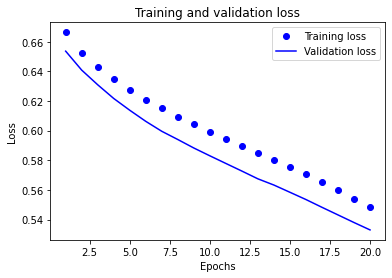

In [14]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Plot accuracy

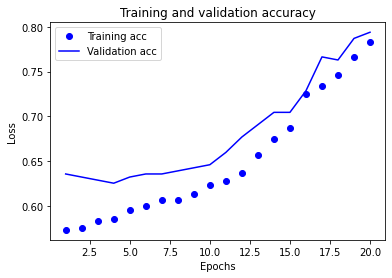

In [78]:
plt.clf()

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Make predictions for test data

In [100]:
# read test data from csv
with open('data/test.csv',newline='') as csvFile:

    reader = csv.reader(csvFile, delimiter=',')

    l = list(reader)
    testHeader = l[0]
    testRawData = l[1:]

# data no longer contains survival info at position 1
testNumericFields = [i-1 for i in numericFields]
testConvertFields = [i-1 for i in convertFields]
testNumericDicts = {field:getNumericDict(testRawData,field) for field in testConvertFields}

# parse test data
testData = parseRawData(testRawData,testConvertFields,testNumericFields,testNumericDicts)
testNormData = normalizeData(testData)
testIDs = [passenger[0] for passenger in testRawData]

# get predictions as list of each [id, survived]
predictions = model.predict(testNormData).tolist()
results = [[int(testIDs[i]),round(predictions[i][0])] for i in range(len(testNormData))]

In [110]:
# write predictions to file for submission

with open('submissions/mySubmission1.csv','w',newline='') as submissionFile:

    writer = csv.writer(submissionFile,delimiter=',')
    writer.writerow(["PassengerID","Survived"])

    for result in results:
        writer.writerow(result)